In [5]:
import dill
import simplejson as json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score

In [163]:
grid_search = dill.load(open('modelnew.pkd', 'rb'))

In [7]:
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler

class Album(object):
    def __init__(self, album_json):
        self.id, self.name, self.genres, self.popularity, self.total_tracks, self.artists_list = [album_json[k] for k in ['id', 'name', 'genres', 'popularity', 'total_tracks', 'artists_list']]
        self.tracks_df = pd.read_json(album_json['tracks_info'], orient='split')

    def unit_transf(self):
        self.tracks_df['tempo'] = self.tracks_df['tempo'] / 60
        self.tracks_df['duration_ms'] = self.tracks_df['duration_ms'] / 1000 / 60
        self.tracks_df['loudness'] = self.tracks_df['loudness'] / 10
        self.tracks_df['ordering'] = MinMaxScaler().fit_transform(self.tracks_df['track_number'].values.reshape(-1,1)) - 0.5
        self.tracks_df['total_tracks'] = self.total_tracks
        
    def classification_label(self):
        self.tracks_df['label'] = self.tracks_df['popularity'] >= self.popularity
        return self.tracks_df['label'].values
        
    def train_X_y(self):
        self.unit_transf()        
        X = self.tracks_df[['mode', 'tempo', 'duration_ms', 'ordering', 'acousticness', 'danceability', 'energy', 'liveness', 'speechiness','valence']].values
        
        poly = PolynomialFeatures(2, interaction_only=True)
        X_order2 = poly.fit_transform(X)
        self.features = poly.get_feature_names(input_features=['mode', 'tempo', 'duration_ms', 'ordering', 'acousticness', 'danceability', 'energy', 'liveness', 'speechiness','valence'])
        
        y = self.classification_label()
#         return X, y
        return X_order2, y

In [14]:
def load_files(year):

    with open("best_seller_albums_v3_year_" + str(year)) as json_file:  
        best_seller_albums_data = json.load(json_file)
        best_seller_albums_albums = [Album(d) for d in best_seller_albums_data]

    with open("top_songs_albums_v3_year_" + str(year)) as json_file:  
        top_songs_albums_data = json.load(json_file)
        top_songs_albums_albums = [Album(d) for d in top_songs_albums_data]

    return best_seller_albums_albums, top_songs_albums_albums


In [15]:
train_list = []
for year in range(14,19):    
    album_list, song_list = load_files('20' + str(year))
    train_list += (album_list + song_list)

In [16]:
X_ls, y_ls = list(zip(*[a.train_X_y() for a in train_list]))
X = np.vstack(X_ls)
y = np.hstack(y_ls)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [159]:
print('total number of data points in the training set: {}'.format(len(y_train)))
print('the number points in the positive class: {}'.format(np.count_nonzero(y_train)))

total number of data points in the training set: 5879
the number points in the positive class: 518


In [157]:
positive_class_indices = list(np.arange(len(y_train))[y_train])
negative_class_indices = list(np.arange(len(y_train))[y_train==False])

a = train_list[0]
ordering_index = a.features.index('ordering')
ordering = X_train[:,ordering_index]

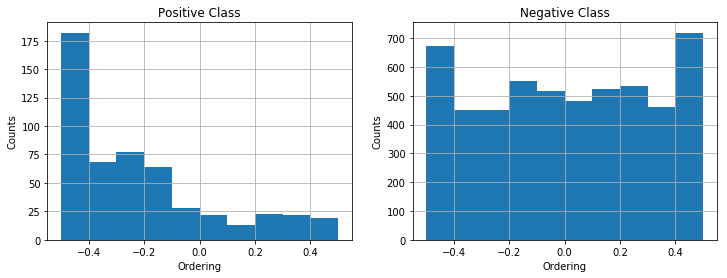

In [148]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.subplot(121)
p_n, p_bins, p_patches = plt.hist(ordering[positive_class_indices], 10)
plt.xlabel('Ordering')
plt.ylabel('Counts')
plt.title('Positive Class')
plt.grid(True)

plt.subplot(122)
n_n, n_bins, n_patches = plt.hist(ordering[negative_class_indices], 10)
plt.xlabel('Ordering')
plt.ylabel('Counts')
plt.title('Negative Class')
plt.grid(True)

plt.show()

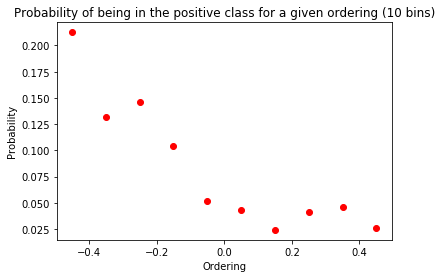

In [151]:
ordering_numeric = [(p_bins[i] + p_bins[i+1])/2 for i in range(len(p_n))]
plt.plot(ordering_numeric , p_n / (p_n + n_n), 'ro')
plt.xlabel('Ordering')
plt.ylabel('Probability')
plt.title('Probability of being in the positive class for a given ordering (10 bins)')
plt.show()

In [184]:
print('While the overall probability of being in the positive class is {}, the first four ordering indices would all perform better than the average. '\
      'Note that there are two local maxima, and it is interesting to note that the second local maximum, {}, is close to the mean of the ordering of the positive cases.'
      .format(np.count_nonzero(y_train)/len(y_train), ordering_numeric[2]))

While the overall probability of being in the positive class is 0.08811022282701139, the first four ordering indices would all perform better than the average. Note that there are two local maxima, and it is interesting to note that the second local maximum, -0.24999999999999994, is close to the mean of the ordering of the positive cases.


In [164]:
print('mean of the ordering of the positive cases: {}'.format(np.mean(ordering[positive_class_indices])))
print('standard deviation: {}'.format(np.std(ordering[positive_class_indices])))

mean of the ordering of the positive cases: -0.22157971324993633
standard deviation: 0.27795704673183347
